**Klasifikasi Aktivitas Otak Manusia**




In [ ]:
from google.colab import drive
drive.mount("/content/drive")

#library Plot
#import matplotlib as mpl

#jika dari dataset github
#dataset = "https://raw.githubusercontent.com/arifadli/DatasetRepository/master/Datasets/sst_nino3.dat.txt"

from collections import defaultdict, Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.signal import welch
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
activities_description = {
    1: 'walking',
    2: 'walking upstairs',
    3: 'walking downstairs',
    4: 'sitting',
    5: 'standing',
    6: 'laying'
}

def read_signals(filename):
    with open(filename, 'r') as fp:
        data = fp.read().splitlines()
        data = map(lambda x: x.rstrip().lstrip().split(), data)
        data = [list(map(float, line)) for line in data]
    return data

def read_labels(filename):        
    with open(filename, 'r') as fp:
        activities = fp.read().splitlines()
        activities = list(map(int, activities))
    return activities

def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation, :, :]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels

In [ ]:
def get_values(y_values, T, N, f_s):
    y_values = y_values
    x_values = [sample_rate * kk for kk in range(0,len(y_values))]
    return x_values, y_values

def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[len(result)//2:]

def get_autocorr_values(y_values, T, N, f_s):
    autocorr_values = autocorr(y_values)
    x_values = np.array([T * jj for jj in range(0, N)])
    return x_values, autocorr_values

In [ ]:
def detect_peaks(x, mph=None, mpd=1, threshold=0, edge='rising',
                 kpsh=False, valley=False, show=False, ax=None):

    """Detect peaks in data based on their amplitude and other features.

    Parameters
    ----------
    x : 1D array_like
        data.
    mph : {None, number}, optional (default = None)
        detect peaks that are greater than minimum peak height.
    mpd : positive integer, optional (default = 1)
        detect peaks that are at least separated by minimum peak distance (in
        number of data).
    threshold : positive number, optional (default = 0)
        detect peaks (valleys) that are greater (smaller) than `threshold`
        in relation to their immediate neighbors.
    edge : {None, 'rising', 'falling', 'both'}, optional (default = 'rising')
        for a flat peak, keep only the rising edge ('rising'), only the
        falling edge ('falling'), both edges ('both'), or don't detect a
        flat peak (None).
    kpsh : bool, optional (default = False)
        keep peaks with same height even if they are closer than `mpd`.
    valley : bool, optional (default = False)
        if True (1), detect valleys (local minima) instead of peaks.
    show : bool, optional (default = False)
        if True (1), plot data in matplotlib figure.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ind : 1D array_like
        indeces of the peaks in `x`.

    Notes
    -----
    The detection of valleys instead of peaks is performed internally by simply
    negating the data: `ind_valleys = detect_peaks(-x)`
    
    The function can handle NaN's 

    See this IPython Notebook [1]_.

    References
    ----------
    .. [1] http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectPeaks.ipynb

    Examples
    --------
    >>> from detect_peaks import detect_peaks
    >>> x = np.random.randn(100)
    >>> x[60:81] = np.nan
    >>> # detect all peaks and plot data
    >>> ind = detect_peaks(x, show=True)
    >>> print(ind)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # set minimum peak height = 0 and minimum peak distance = 20
    >>> detect_peaks(x, mph=0, mpd=20, show=True)

    >>> x = [0, 1, 0, 2, 0, 3, 0, 2, 0, 1, 0]
    >>> # set minimum peak distance = 2
    >>> detect_peaks(x, mpd=2, show=True)

    >>> x = np.sin(2*np.pi*5*np.linspace(0, 1, 200)) + np.random.randn(200)/5
    >>> # detection of valleys instead of peaks
    >>> detect_peaks(x, mph=0, mpd=20, valley=True, show=True)

    >>> x = [0, 1, 1, 0, 1, 1, 0]
    >>> # detect both edges
    >>> detect_peaks(x, edge='both', show=True)

    >>> x = [-2, 1, -2, 2, 1, 1, 3, 0]
    >>> # set threshold = 2
    >>> detect_peaks(x, threshold = 2, show=True)
    """

    x = np.atleast_1d(x).astype('float64')
    if x.size < 3:
        return np.array([], dtype=int)
    if valley:
        x = -x
    # find indices of all peaks
    dx = x[1:] - x[:-1]
    # handle NaN's
    indnan = np.where(np.isnan(x))[0]
    if indnan.size:
        x[indnan] = np.inf
        dx[np.where(np.isnan(dx))[0]] = np.inf
    ine, ire, ife = np.array([[], [], []], dtype=int)
    if not edge:
        ine = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) > 0))[0]
    else:
        if edge.lower() in ['rising', 'both']:
            ire = np.where((np.hstack((dx, 0)) <= 0) & (np.hstack((0, dx)) > 0))[0]
        if edge.lower() in ['falling', 'both']:
            ife = np.where((np.hstack((dx, 0)) < 0) & (np.hstack((0, dx)) >= 0))[0]
    ind = np.unique(np.hstack((ine, ire, ife)))
    # handle NaN's
    if ind.size and indnan.size:
        # NaN's and values close to NaN's cannot be peaks
        ind = ind[np.in1d(ind, np.unique(np.hstack((indnan, indnan-1, indnan+1))), invert=True)]
    # first and last values of x cannot be peaks
    if ind.size and ind[0] == 0:
        ind = ind[1:]
    if ind.size and ind[-1] == x.size-1:
        ind = ind[:-1]
    # remove peaks < minimum peak height
    if ind.size and mph is not None:
        ind = ind[x[ind] >= mph]
    # remove peaks - neighbors < threshold
    if ind.size and threshold > 0:
        dx = np.min(np.vstack([x[ind]-x[ind-1], x[ind]-x[ind+1]]), axis=0)
        ind = np.delete(ind, np.where(dx < threshold)[0])
    # detect small peaks closer than minimum peak distance
    if ind.size and mpd > 1:
        ind = ind[np.argsort(x[ind])][::-1]  # sort ind by peak height
        idel = np.zeros(ind.size, dtype=bool)
        for i in range(ind.size):
            if not idel[i]:
                # keep peaks with the same height if kpsh is True
                idel = idel | (ind >= ind[i] - mpd) & (ind <= ind[i] + mpd) \
                    & (x[ind[i]] > x[ind] if kpsh else True)
                idel[i] = 0  # Keep current peak
        # remove the small peaks and sort back the indices by their occurrence
        ind = np.sort(ind[~idel])

    if show:
        if indnan.size:
            x[indnan] = np.nan
        if valley:
            x = -x
        _plot(x, mph, mpd, threshold, edge, valley, ax, ind)

    return ind

In [ ]:
INPUT_FOLDER_TRAIN = '/content/drive/My Drive/11_Dataset_Repository/UCI_HAR_Dataset/train/Inertial_Signals/'
INPUT_FOLDER_TEST = '/content/drive/My Drive/11_Dataset_Repository/UCI_HAR_Dataset/test/Inertial_Signals/'

INPUT_FILES_TRAIN = ['body_acc_x_train.txt', 'body_acc_y_train.txt', 'body_acc_z_train.txt', 
                     'body_gyro_x_train.txt', 'body_gyro_y_train.txt', 'body_gyro_z_train.txt',
                     'total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']

INPUT_FILES_TEST = ['body_acc_x_test.txt', 'body_acc_y_test.txt', 'body_acc_z_test.txt', 
                     'body_gyro_x_test.txt', 'body_gyro_y_test.txt', 'body_gyro_z_test.txt',
                     'total_acc_x_test.txt', 'total_acc_y_test.txt', 'total_acc_z_test.txt']

LABELFILE_TRAIN = '/content/drive/My Drive/11_Dataset_Repository/UCI_HAR_Dataset/train/y_train.txt'
LABELFILE_TEST = '/content/drive/My Drive/11_Dataset_Repository/UCI_HAR_Dataset/test/y_test.txt'

train_signals, test_signals = [], []

for input_file in INPUT_FILES_TRAIN:
    signal = read_signals(INPUT_FOLDER_TRAIN + input_file)
    train_signals.append(signal)
train_signals = np.transpose(np.array(train_signals), (1, 2, 0))

for input_file in INPUT_FILES_TEST:
    signal = read_signals(INPUT_FOLDER_TEST + input_file)
    test_signals.append(signal)
test_signals = np.transpose(np.array(test_signals), (1, 2, 0))

train_labels = read_labels(LABELFILE_TRAIN)
test_labels = read_labels(LABELFILE_TEST)

[no_signals_train, no_steps_train, no_components_train] = np.shape(train_signals)
[no_signals_test, no_steps_test, no_components_test] = np.shape(test_signals)
no_labels = len(np.unique(train_labels[:]))

print("Jumlah data pelatihan {} sinyal\nSetiap sinyal memiliki panjang {} (50 x 2.56)  dan memiliki {} komponen ".format(no_signals_train, no_steps_train, no_components_train))
print(" ")
print("Jumlah data pengujian {} sinyal\nSetiap sinyal memiliki panjang {}(50 x 2.56) dan memiliki {} komponen ".format(no_signals_test, no_steps_test, no_components_test))
print(" ")
print("Jumlah label data pelatihan {} label\nDengan distribusi: {}".format(np.shape(train_labels)[0], Counter(train_labels[:])))
print(" ")
print("Jumlah label data pengujian {} label\nDengan distribusi: {}".format(np.shape(test_labels)[0], Counter(test_labels[:])))
print(" ")
train_signals, train_labels = randomize(train_signals, np.array(train_labels))
test_signals, test_labels = randomize(test_signals, np.array(test_labels))

Jumlah data pelatihan 7352 sinyal
Setiap sinyal memiliki panjang 128 (50 x 2.56)  dan memiliki 9 komponen 
 
Jumlah data pengujian 2947 sinyal
Setiap sinyal memiliki panjang 128(50 x 2.56) dan memiliki 9 komponen 
 
Jumlah label data pelatihan 7352 label
Dengan distribusi: Counter({6: 1407, 5: 1374, 4: 1286, 1: 1226, 2: 1073, 3: 986})
 
Jumlah label data pengujian 2947 label
Dengan distribusi: Counter({6: 537, 5: 532, 1: 496, 4: 491, 2: 471, 3: 420})
 


In [ ]:
N = 128
f_s = 50
t_n = 2.56
T = t_n / N
sample_rate = f_s

In [ ]:
signal_no = 15
signals = train_signals[signal_no, :, :]
signal = signals[:, 3]
label = train_labels[signal_no]
activity_name = activities_description[label]

Contoh visualisasi dengan FFT

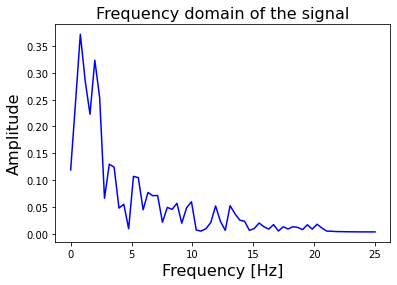

In [ ]:
f_values, fft_values = get_fft_values(signal, T, N, f_s)

plt.plot(f_values, fft_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.title("Frequency domain of the signal", fontsize=16)
plt.show()

Contoh visualisasi dengan PSD


/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


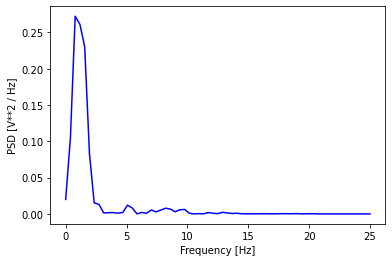

In [ ]:
f_values, psd_values = get_psd_values(signal, T, N, f_s)
 
plt.plot(f_values, psd_values, linestyle='-', color='blue')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [V**2 / Hz]')
plt.show()

Contoh visualisasi dengan Autokorelasi

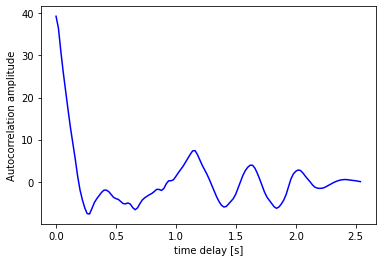

In [ ]:
t_values, autocorr_values = get_autocorr_values(signal, T, N, f_s)
 
plt.plot(t_values, autocorr_values, linestyle='-', color='blue')
plt.xlabel('time delay [s]')
plt.ylabel('Autocorrelation amplitude')
plt.show()

Visualisasi Komponen Sinyal Aktivitas Otak

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))
/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral

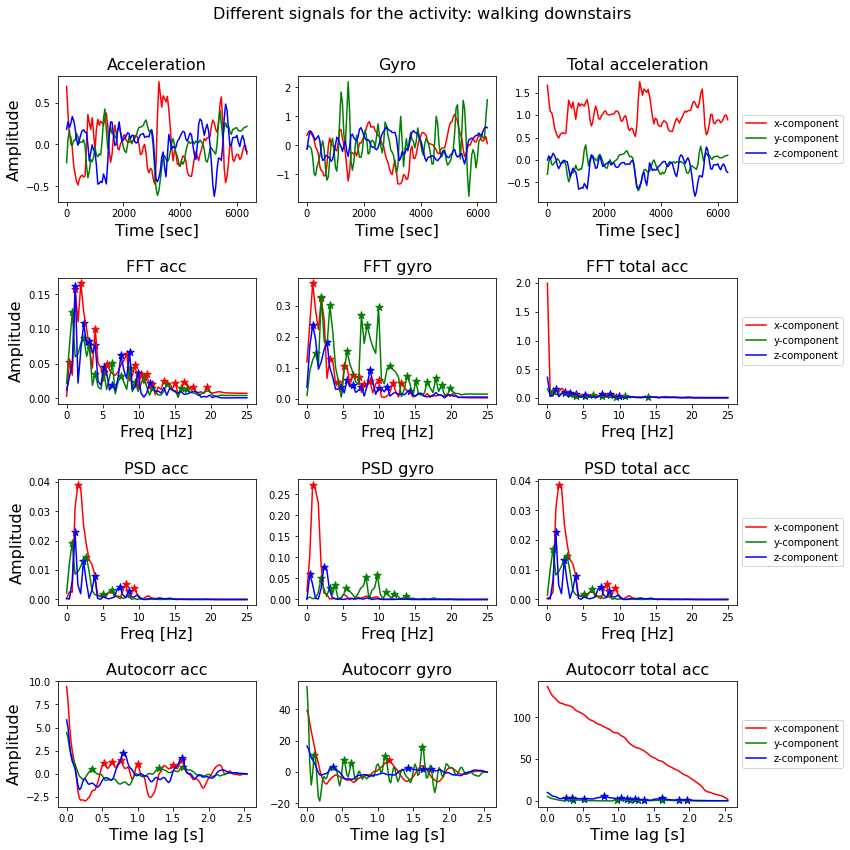

In [ ]:
labels = ['x-component', 'y-component', 'z-component']
colors = ['r', 'g', 'b']
suptitle = "Different signals for the activity: {}"
 
xlabels = ['Time [sec]', 'Freq [Hz]', 'Freq [Hz]', 'Time lag [s]']
ylabel = 'Amplitude'
axtitles = [['Acceleration', 'Gyro', 'Total acceleration'],
            ['FFT acc', 'FFT gyro', 'FFT total acc'],
            ['PSD acc', 'PSD gyro', 'PSD total acc'],
            ['Autocorr acc', 'Autocorr gyro', 'Autocorr total acc']
           ]
 
list_functions = [get_values, get_fft_values, get_psd_values, get_autocorr_values]

f, axarr = plt.subplots(nrows=4, ncols=3, figsize=(12,12))
f.suptitle(suptitle.format(activity_name), fontsize=16)
 
for row_no in range(0,4):
    for comp_no in range(0,9):
        col_no = comp_no // 3
        plot_no = comp_no % 3
        color = colors[plot_no]
        label = labels[plot_no]
 
        axtitle  = axtitles[row_no][col_no]
        xlabel = xlabels[row_no]
        value_retriever = list_functions[row_no]
 
        ax = axarr[row_no, col_no]
        ax.set_title(axtitle, fontsize=16)
        ax.set_xlabel(xlabel, fontsize=16)
        if col_no == 0:
            ax.set_ylabel(ylabel, fontsize=16)
 
        signal_component = signals[:, comp_no]
        x_values, y_values = value_retriever(signal_component, T, N, f_s)
        ax.plot(x_values, y_values, linestyle='-', color=color, label=label)
        if row_no > 0:
            max_peak_height = 0.1 * np.nanmax(y_values)
            indices_peaks = detect_peaks(y_values, mph=max_peak_height)
            ax.scatter(x_values[indices_peaks], y_values[indices_peaks], c=color, marker='*', s=60)
        if col_no == 2:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))            
plt.tight_layout()
plt.subplots_adjust(top=0.90, hspace=0.6)
plt.show()

Klasifikasi Sinyal Menggunakan Random Forest

In [ ]:
def get_first_n_peaks(x,y,no_peaks=5):
    x_, y_ = list(x), list(y)
    if len(x_) >= no_peaks:
        return x_[:no_peaks], y_[:no_peaks]
    else:
        missing_no_peaks = no_peaks-len(x_)
        return x_ + [0]*missing_no_peaks, y_ + [0]*missing_no_peaks
    
def get_features(x_values, y_values, mph):
    indices_peaks = detect_peaks(y_values, mph=mph)
    peaks_x, peaks_y = get_first_n_peaks(x_values[indices_peaks], y_values[indices_peaks])
    return peaks_x + peaks_y

def extract_features_labels(dataset, labels, T, N, f_s, denominator):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    for signal_no in range(0, len(dataset)):
        features = []
        list_of_labels.append(labels[signal_no])
        for signal_comp in range(0,dataset.shape[2]):
            signal = dataset[signal_no, :, signal_comp]
            
            signal_min = np.nanpercentile(signal, percentile)
            signal_max = np.nanpercentile(signal, 100-percentile)
            #ijk = (100 - 2*percentile)/10
            mph = signal_min + (signal_max - signal_min)/denominator
            
            features += get_features(*get_psd_values(signal, T, N, f_s), mph)
            features += get_features(*get_fft_values(signal, T, N, f_s), mph)
            features += get_features(*get_autocorr_values(signal, T, N, f_s), mph)
        list_of_features.append(features)
    return np.array(list_of_features), np.array(list_of_labels)

denominator = 10

In [ ]:
X_train, Y_train = extract_features_labels(train_signals, train_labels, T, N, f_s, denominator)
X_test, Y_test = extract_features_labels(test_signals, test_labels, T, N, f_s, denominator)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)

print("Accuracy on training set is : {}".format(clf.score(X_train, Y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, Y_test)))
Y_test_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_test_pred))

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  .format(nperseg, input_length))


Accuracy on training set is : 1.0
Accuracy on test set is : 0.8812351543942993
              precision    recall  f1-score   support

           1       0.94      0.97      0.96       496
           2       0.93      0.96      0.94       471
           3       0.95      0.88      0.91       420
           4       0.79      0.75      0.77       491
           5       0.78      0.93      0.85       532
           6       0.93      0.81      0.87       537

    accuracy                           0.88      2947
   macro avg       0.89      0.88      0.88      2947
weighted avg       0.89      0.88      0.88      2947

